In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"]
})

In [2]:
common_settings = {
'omega_b':0.022,
'h':0.67810,
'z_reio':7.6711,
'YHe':0.25,
'perturbations_verbose':1,
'background_verbose':3,
'output':'mTk, vTk, mPk',
'gauge':'newtonian',
'P_k_max_1/Mpc':10,
'z_max_pk':1000,
'format':'class',
}

In [3]:
chiCDM = Class()
# pass input parameters
chiCDM.set(common_settings)
aNR=1.e-7
f_chi=0.1
print(f'aNR={aNR},zNR={1/aNR -1}')
chiCDM.set({
# 'N_ur': 3.046,
'omega_cdm':0.12,
# 'omega_cdm':0.08,

'f_chi':f_chi,
'acs_chi':aNR,
'cs2_peak_chi':1./3.,
# 'T_cmb':1.7,
})
chiCDM.compute()



aNR=1e-07,zNR=9999999.0
Running CLASS version v3.2.0
Computing background
Chose ndf15 as generic_evolver
 -> age = 13.379258 Gyr
 -> conformal age = 13591.123047 Mpc
 -> N_eff = 3.044 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3771.254146
    corresponding to conformal time = 101.800901 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0478448       , omega = 0.022          
-> Cold Dark Matter               Omega = 0.260972        , omega = 0.12           
-> Dark Matter with sound speed:  Omega = 0.034313        , omega = 0.0157778      
 ---> Relativistic Species 
-> Photons                        Omega = 5.37815e-05     , omega = 2.47298e-05    
-> Ultra-relativistic relics      Omega = 3.71799e-05     , omega = 1.70961e-05    
 ---> Other Content 
-> Cosmological Constant          Omega = 0.656779        , omega = 0.302  

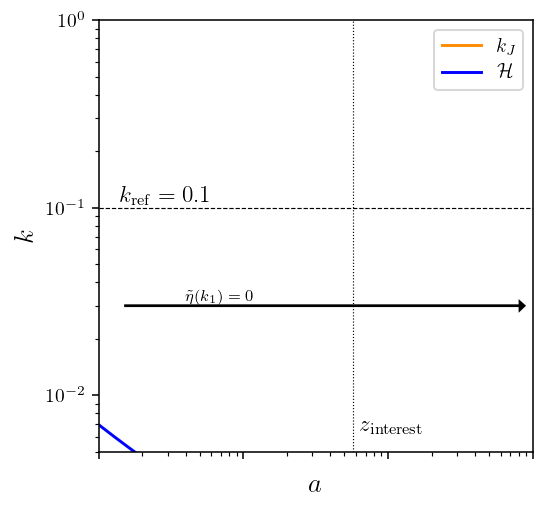

In [4]:
plt.figure(figsize=(4.,4), dpi=140)

background = chiCDM.get_background() # load background table
a = 1/(background['z']+1) # read redshift
rho_cdm=background['(.)rho_cdm']
rho_chi=background['(.)rho_chi']
kJ_chi=background['(.)kJ_chi']
D_class_int = interp1d(a,background['gr.fac. D'])
Ha=background['H [1/Mpc]']/(1.+background['z'])
Ha_chi_int=interp1d(a,Ha)

kJ_int=interp1d(a,kJ_chi)

plt.xlabel(r'$a $')

h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc

# plt.loglog(background_a,cFS2_nu,label=r'cFS')
plt.loglog(a,kJ_chi,'darkorange',label=r'$k_J$')

plt.loglog(a,Ha/h,'blue',label=r'$\mathcal{H}$')

# plt.fill_between([a_ini,a_end], 0.01,1, color='crimson', alpha=0.3)


plt.axhline(y=0.1, color='k', linewidth=0.6, linestyle = '--')
plt.text(0.05, 0.58, r'$k_\mathrm{ref}=0.1$', transform=plt.gca().transAxes, fontsize=12)

plt.axvline(x=0.057, color='k', linewidth=0.6, linestyle = ':')
plt.text(0.6, 0.05, r'$z_\mathrm{interest}$', transform=plt.gca().transAxes, fontsize=12)

plt.arrow(1.5e-3, 3.e-2, (0.8-2e-3), 0, head_width=0.005, head_length=0.1, linewidth=0.01,fc='k', ec='k')
plt.text(0.2, 0.35, r'$\tilde{\eta}(k_1)=0$', transform=plt.gca().transAxes, fontsize=8)


plt.xlim([1.e-3,1])
plt.ylim([5.e-3,1])

plt.legend()
plt.xscale('log')
plt.xlabel(r'$a$', fontsize=14)
plt.ylabel(r'$k$', fontsize=14)
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/kjeans-kref.pdf',bbox_inches='tight')
plt.gca().set_xticklabels([])

plt.show()


----
as a function of k

In [5]:
z_ini = 10
z_end = 5
a_ini = 1/(z_ini+1);a_end = 1/(z_end+1)

kk = np.logspace(-3.,0.,100) # k in h/Mpc
Pk_ini = [] # P(k) in (Mpc/h)**3
Pk_end = [] # P(k) in (Mpc/h)**3

h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc
for k in kk:
    Pk_ini.append(chiCDM.pk_cb_lin(k*h,z_ini)*h**3) # function .pk(k,z)
    Pk_end.append(chiCDM.pk_cb_lin(k*h,z_end)*h**3) # function .pk(k,z)

Pk_ini=np.array(Pk_ini);Pk_end=np.array(Pk_end)


chi_tk_k = chiCDM.get_transfer(z=z_end)
f_b_overcb = 0.022/(0.12+0.022)
cb_chi = -(1-f_b_overcb)*chi_tk_k['d_cdm']-f_b_overcb*chi_tk_k['d_cdm']
kEval=chi_tk_k['k (h/Mpc)']
ratio_end=-chi_tk_k['d_cdm']/chi_tk_k['d_m']
d_cdm_k=-chi_tk_k['d_cdm']

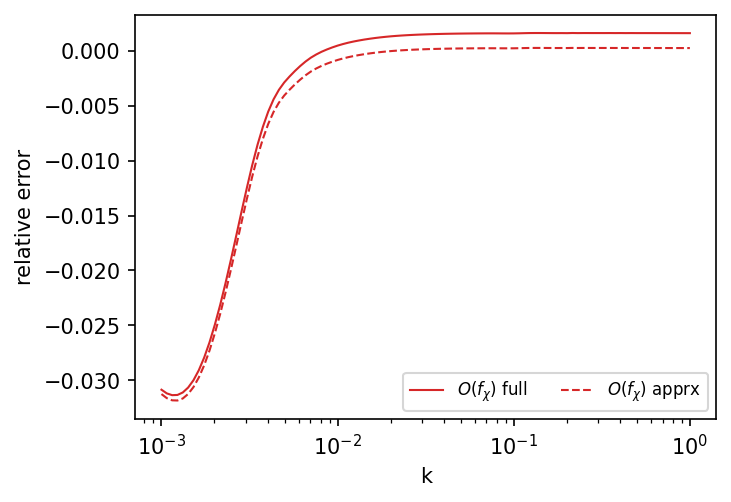

In [6]:
from scipy.integrate import odeint

## START WITH g AND h 
def gh_system(w, t):
    g,h = w
    dgdt = h - g
    dhdt = 3/2 *(1-h)-3/2*np.exp(-t)*g
    return [dgdt, dhdt]
w0 = [0.,0.]
t = np.linspace(-10,30, 100)  #t is tilde eta
sol = odeint(gh_system, w0, t)
g_int = interp1d(t, sol[:, 0])
h_int = interp1d(t, sol[:, 1])

def s1_system(s1, t):
    ds1dt = -2.5*s1+1.5*(g_int(t)-1)
    return ds1dt
t = np.linspace(-10,25, 100)
sol = odeint(s1_system, -3/5, t)
s_int_te = interp1d(t, sol[:, 0], fill_value='extrapolate')

D_ini=D_class_int(a_ini);D_end=D_class_int(a_end)
# D_ini=a_ini;D_end=a_end


# compute growth factor for every k
Delta_logD_k=[]
Delta_logD_ini=[];Delta_logD_end=[]
adjust=0.
for k in kk:
    te_ini_of_ak=np.log(a_ini/aNR) - 2*np.log(k/kJ_int(aNR)) +adjust
    te_end_of_ak=np.log(a_end/aNR) - 2*np.log(k/kJ_int(aNR))+adjust
    D_integral, D_error = quad(s_int_te, te_ini_of_ak, te_end_of_ak,epsrel=1.e-4)
    # a_of_t = D_ini* ((k/kJ_int(a_ini))**2 ) * np.exp(t) 
    # s_int_loga = interp1d(np.log(a_of_t), sol[:, 0], fill_value='extrapolate')
    # D_integral, D_error = quad(s_int_loga, np.log(D_ini), np.log(D_end),epsrel=1.e-4)
    D_int_es_ini, _ = quad(s_int_te, te_ini_of_ak, 10,epsrel=1.e-4)
    D_int_es_end, _ = quad(s_int_te, te_end_of_ak, 10,epsrel=1.e-4)
    # print(f'k={str(k)}, te_ini={str(te_ini_of_ak)}, te_end={str(te_end_of_ak)}')
    # print(D_int_es_ini,D_int_es_end)
    Delta_logD_k.append(D_integral)
    Delta_logD_ini.append(D_int_es_ini);Delta_logD_end.append(D_int_es_end);

D_k = (D_end/D_ini)*np.exp(f_chi*np.array(Delta_logD_k)) 
P_end_D = Pk_ini * D_k**2

D_k = (D_end/D_ini)*(1 + f_chi*np.array(Delta_logD_k))
P_end_D_approx = Pk_ini * D_k**2

D_k = (D_end/D_ini)*(1  - f_chi*np.array(Delta_logD_end))*np.exp(f_chi*np.array(Delta_logD_ini))
P_end_es = Pk_ini * D_k**2

# D_EdS = np.exp(np.log(a_end/a_ini) )
D_EdS = D_end/D_ini
P_end_D_EdS = Pk_ini * D_EdS**2
# P_end_D_EdS = Pk_ini * (D_class_int(a_end)/D_class_int(a_ini))**2

# error_pure_cdm=np.abs(P_end_D_EdS/Pk_end-1)

plt.figure(figsize=(5.,3.5), dpi=150)
# plt.plot(kk, -np.array(Delta_logD_k),'firebrick',label=r'$g(\tilde \eta (a=0.1,k))$')


# plt.plot(kk, error_pure_cdm,'k',linestyle=':',label=r'EdS (pure CDM)')
# plt.plot(kk, P_end_D_EdS/Pk_end-1,'navy',linestyle='-',label=r'EdS', linewidth=1.)
plt.plot(kk, P_end_D/Pk_end-1,'tab:red',label=r'$O(f_\chi)$ full', linewidth=1.)
plt.plot(kk, P_end_D_approx/Pk_end-1,'tab:red',label=r'$O(f_\chi)$ apprx',linestyle='--', linewidth=1.)
# plt.plot(kk, P_end_es/Pk_end-1,'green',label=r'new apprx',linestyle='--', linewidth=1.)

# plt.axhline(y=1, color='k', linewidth=0.7)
plt.xscale('log')
# plt.yscale('symlog')
# plt.ylim([3.e-3,1])
plt.xlabel('k')
plt.ylabel('relative error')
plt.legend(loc='best', fontsize=8, ncol=2)
# plt.text(0.012, 2, r'$f_\chi = '+str(int(f_chi*100))+'\%, \; z_{ini}='+str(z_ini)+',\; z_{end}='+str(z_end)+'$', fontsize=12)


# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/growthfacr-error-fx01.pdf',bbox_inches='tight')
plt.show()

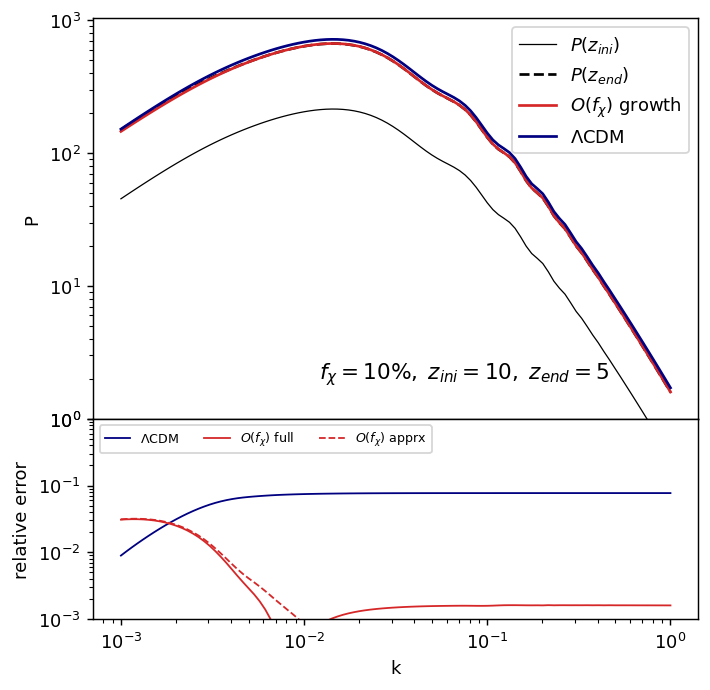

In [7]:
fig, axs = plt.subplots(2, 1, sharex=True,gridspec_kw={'height_ratios': [2,1]}, figsize=(6,6), dpi=130)
plt.subplots_adjust(hspace = 0)

axs[0].loglog(kk, Pk_ini,'k',label=r'$P(z_{ini})$', linewidth=0.7)
axs[0].plot(kk, Pk_end,'k--',label=r'$P(z_{end})$')
axs[0].plot(kk, P_end_D,'tab:red',label=r'$O(f_\chi)$ growth')
axs[0].plot(kk, P_end_D_EdS,'navy',label=r'$\Lambda$CDM')



# axs[1].plot(kk, error_pure_cdm,'k',linestyle=':',label=r'EdS (pure CDM)', linewidth=1)
axs[1].plot(kk, np.abs(P_end_D_EdS/Pk_end-1),'navy',linestyle='-',label=r'$\Lambda$CDM', linewidth=1.)
axs[1].plot(kk, np.abs(P_end_D/Pk_end-1),'tab:red',label=r'$O(f_\chi)$ full', linewidth=1.)
axs[1].plot(kk, np.abs(P_end_D_approx/Pk_end-1),'tab:red',label=r'$O(f_\chi)$ apprx',linestyle='--', linewidth=1.)


axs[0].text(0.012, 2, r'$f_\chi = '+str(int(f_chi*100))+'\%, \; z_{ini}='+str(z_ini)+',\; z_{end}='+str(z_end)+'$', fontsize=12)


axs[0].legend(loc='best')
# axs[0].set_xlim([1.e-2,1])
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xlabel('k')
axs[1].legend(loc='upper left', fontsize=7, ncol=4)
axs[1].set_yscale('log')
axs[1].set_ylim([1.e-3,1])
axs[0].set_ylim([1,None])
axs[0].set_ylabel('P')
axs[1].set_ylabel('relative error')

# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/growthfact-error-fx01-zini25-zend0p5.pdf',bbox_inches='tight')

plt.show()

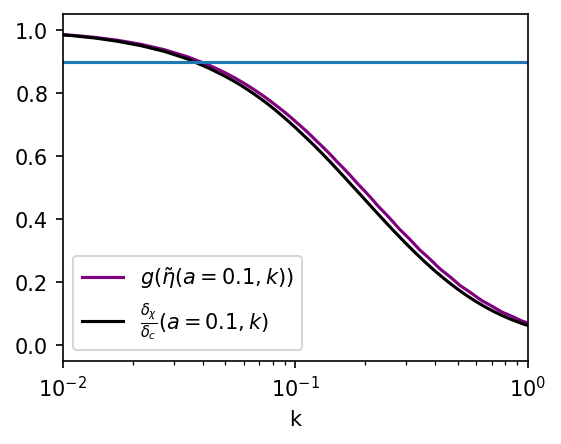

In [134]:
zeval = 1.
aeval=1/(zeval+1)
chi_tk_k = chiCDM.get_transfer(z=zeval)

kEval=chi_tk_k['k (h/Mpc)']

d_chi_k=-chi_tk_k['d_chi']
d_cdm_k=-chi_tk_k['d_cdm']

T_ratio_k =d_chi_k/ d_cdm_k
fb=0.0223828 /(0.12+0.0223828)
d_cb = (1-fb)*chi_tk_k['d_cdm']+fb*chi_tk_k['d_b']
# T_ratio_k =chi_tk_k['d_m']/ chi_tk_k['d_cdm']


def gh_system(w, t):
    g,h = w
    dgdt = h - g
    dhdt = 3/2 *(1-h)-3/2*np.exp(-t)*g
    return [dgdt, dhdt]
w0 = [0.,0.]
t = np.linspace(-10,30, 100)  #t is tilde eta
sol = odeint(gh_system, w0, t)
k_of_t = kJ_int(aNR)* np.sqrt(aeval/aNR) * np.exp(-0.5*t) 
# k_of_t = kJ_int(aNR)* np.sqrt(D_class_int(aeval)/D_class_int(aNR)) * np.exp(-0.5*t) 

g_int_k = interp1d(k_of_t, sol[:, 0], fill_value='extrapolate')
plt.figure(figsize=(4,3), dpi=150)


plt.plot(kEval, g_int_k(kEval),'purple',label=r'$g(\tilde \eta (a=0.1,k))$')
plt.plot(kEval, T_ratio_k,'k',label=r'$\frac{\delta_\chi}{\delta_c}(a=0.1,k)$')
plt.axhline(y=0.9)
# plt.axhline(y=1, color='k', linewidth=0.7)
plt.xscale('log')
plt.xlabel('k')
plt.legend()
plt.xlim([1.e-2,1])
plt.show()

In [8]:
f_chi_list = [1.e-10,0.01,0.05,0.1,0.2]
reldiff_list=[]
z_ini = 50
z_end = 20
a_ini = 1/(z_ini+1);a_end = 1/(z_end+1)

def gh_system(w, t):
    g,h = w
    dgdt = h - g
    dhdt = 3/2 *(1-h)-3/2*np.exp(-t)*g
    return [dgdt, dhdt]
w0 = [0.,0.]
t = np.linspace(-10,30, 100)  #t is tilde eta
sol = odeint(gh_system, w0, t)
g_int = interp1d(t, sol[:, 0])
h_int = interp1d(t, sol[:, 1])

def s1_system(s1, t):
    ds1dt = -2.5*s1+1.5*(g_int(t)-1)
    return ds1dt
t = np.linspace(-10,20, 100)
sol = odeint(s1_system, -3/5, t)
s_int_te = interp1d(t, sol[:, 0], fill_value='extrapolate')

for f_chi in f_chi_list:
    chiCDM.set({
    'f_chi':f_chi,
    'perturbations_verbose':0,
    'background_verbose':0,
    })
    chiCDM.compute()

    kk = np.logspace(-2,-0.,100) # k in h/Mpc
    Pk_ini = [] # P(k) in (Mpc/h)**3
    Pk_end = [] # P(k) in (Mpc/h)**3
    h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc
    for k in kk:
        Pk_ini.append(chiCDM.pk_cb_lin(k*h,z_ini)*h**3) # function .pk(k,z)
        Pk_end.append(chiCDM.pk_cb_lin(k*h,z_end)*h**3) # function .pk(k,z)
    Pk_ini=np.array(Pk_ini);Pk_end=np.array(Pk_end)

    Delta_logD_k=[]
    for k in kk:
        te_ini_of_ak=np.log(a_ini/aNR) - 2*np.log(k/kJ_int(aNR))
        te_end_of_ak=np.log(a_end/aNR) - 2*np.log(k/kJ_int(aNR))
        D_integral, D_error = quad(s_int_te, te_ini_of_ak, te_end_of_ak,epsrel=1.e-4)
        Delta_logD_k.append(D_integral)

    D_k = (a_end/a_ini)*np.exp(f_chi*np.array(Delta_logD_k)) 
    # D_k = (D_class_int(a_end)/D_class_int(a_ini))*np.exp(f_chi*np.array(Delta_logD_k)) 

    P_end_D = Pk_ini * D_k**2

    reldiff_list.append(P_end_D/Pk_end-1)

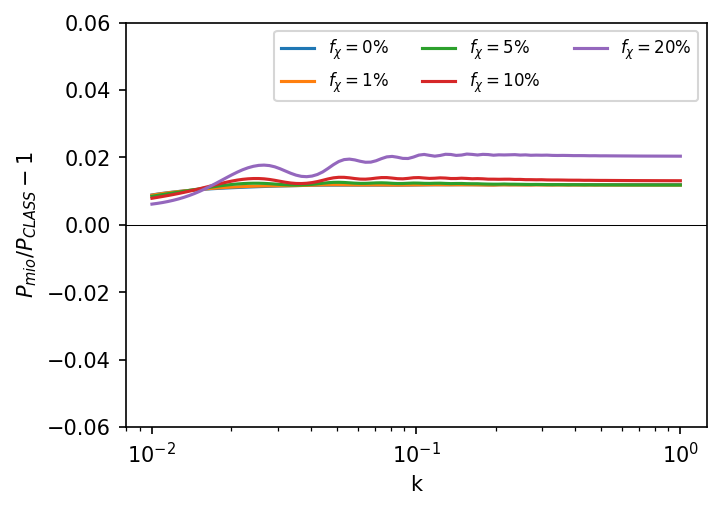

In [9]:
plt.figure(figsize=(5.,3.5), dpi=150)
for i in range(len(f_chi_list)):
    plt.plot(kk, reldiff_list[i], label=r'$f_\chi = '+str(int(f_chi_list[i]*100))+r'\%$')

plt.axhline(y=0 ,color='k', linewidth=0.5)
plt.xscale('log');#plt.yscale('lin')
plt.ylim([-0.06,0.06])
plt.xlabel('k')
plt.ylabel(r'$P_{mio}/P_{CLASS}-1$')
plt.legend(ncol=3, fontsize=8)
plt.show()